In [21]:
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import signal 

print("Setup Complete")

Setup Complete


In [22]:
ppg_filepath = "../golden_data/ppg_golden_data.csv"

ppg_data = pd.read_csv(ppg_filepath, nrows=1000000)

In [31]:
# Định nghĩa các tham số
fs = 100.0  # Tần số lấy mẫu, ví dụ 50 Hz
lowcut = 0.5  # Tần số cắt thấp, 0.5 Hz
highcut = 5.0  # Tần số cắt cao, 5 Hz
order = 4  # Bậc của bộ lọc

# Hàm tính toán hệ số bộ lọc Butterworth trong miền tần số liên tục (s-domain)
def butter_bandpass_s(lowcut, highcut, fs, order=4):
    
    #b_s = [0, 0, 0, 0, 14641] 
    #a_s = [1, 28.74438523, 413.1198405, 3478.070613, 14641]

    b_s = [0, 0, 0, 0, 410.0625, 0, 0, 0, 0] 
    
    a_s = [1, 11.75906669, 79.13782459, 326.3141006, 793.251623, 815.7852513, 494.6114037, 183.735417, 39.0625]

    return b_s, a_s

def bilinear_transform(b, a, fs):
    
    #b_z = [0, 5.7580e-06, 5.9773e-05, 5.6433e-05, 4.8459e-06]
    #a_z = [1, -3.7128, 5.1789, -3.2162, 0.7502]

    b_z = [0, 1.668746875510892e-07, 1.125222936892873e-06, -4.418585720620133e-06, 3.240126494715658e-06, 2.880278425193117e-06, -4.278449529637947e-06, 1.129025973719708e-06, 1.555067321856335e-07] 
    
    a_z = [1, -7.881440488611725, 27.178018085272930, -53.557535401315930, 65.967830502410950, -52.005912522207050, 25.626087547539484, -7.216107622875697, 0.889059899787052]
    
    return b_z, a_z

# Hàm lọc tín hiệu sử dụng các hệ số z-domain
def apply_filter(data, b, a):
    data = np.asarray(data, dtype=np.float64)  # Đảm bảo dữ liệu đầu vào là kiểu float64
    y = np.zeros_like(data, dtype=np.float64)  # Tạo mảng kết quả kiểu float64
    for i in range(len(data)):
        y[i] = b[0] * data[i]
        for j in range(1, len(b)):
            if i-j >= 0:
                y[i] += b[j] * data[i-j]
        for j in range(1, len(a)):
            if i-j >= 0:
                y[i] -= a[j] * y[i-j]
    return y


In [32]:

b_s, a_s = butter_bandpass_s(lowcut, highcut, fs, order)
print(a_s)
print(b_s)

# Chuyển đổi các hệ số từ miền s sang miền z
b_z, a_z = bilinear_transform(b_s, a_s, fs)
print(a_z)
print(b_z)

# Áp dụng bộ lọc
filtered_sig = apply_filter(ppg_data, b_z, a_z)

[1, 11.75906669, 79.13782459, 326.3141006, 793.251623, 815.7852513, 494.6114037, 183.735417, 39.0625]
[0, 0, 0, 0, 410.0625, 0, 0, 0, 0]
[1, -7.881440488611725, 27.17801808527293, -53.55753540131593, 65.96783050241095, -52.00591252220705, 25.626087547539484, -7.216107622875697, 0.889059899787052]
[0, 1.668746875510892e-07, 1.125222936892873e-06, -4.418585720620133e-06, 3.240126494715658e-06, 2.880278425193117e-06, -4.278449529637947e-06, 1.129025973719708e-06, 1.555067321856335e-07]


In [33]:
print(filtered_sig)
print(ppg_data)

[[0.00000000e+000]
 [1.63704068e-004]
 [2.55827227e-003]
 ...
 [2.01802999e+122]
 [2.02194602e+122]
 [2.02580563e+122]]
        975
0       981
1       984
2       989
3       992
4       994
...     ...
199729  580
199730  553
199731  544
199732  548
199733  558

[199734 rows x 1 columns]


<Axes: >

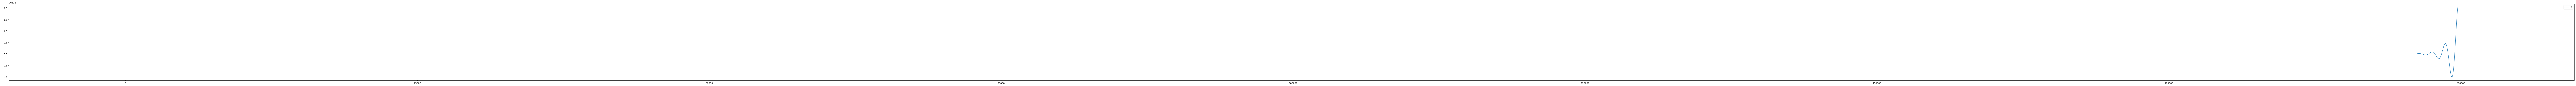

In [34]:
# Hiển thị tín hiệu trước và sau khi lọc
plt.figure(figsize=(200,6))
sns.lineplot(data=filtered_sig)